In [24]:
import sys
sys.path.insert(0, "..")

In [25]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [26]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "Slope"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [27]:
df = get_dataframe(aspect_path, "Slope")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [28]:
def get_mapping(series):
    aspect_raster = access_raster(series['Slope'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        
    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, label='Data', s=1)

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")
    ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} * x^3 + {get_str(b)} * x^2 + {get_str(c)} * x + {get_str(d)}")
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 2))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values
    plot_map(new_mapping)
    return new_mapping

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


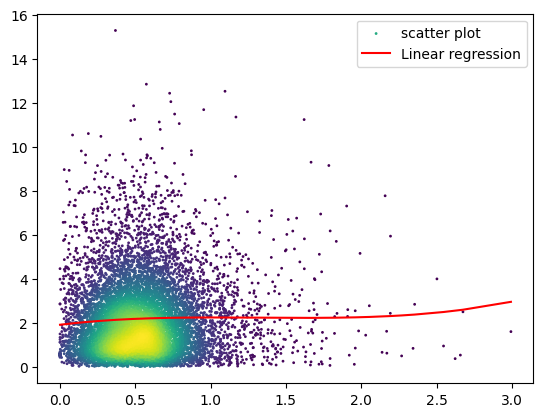

Fitted function: 0.17 * x^3 + -0.66 * x^2 + 0.83 * x + 1.9
MSE: 2.8651254
R^2: 0.0018903613090515137


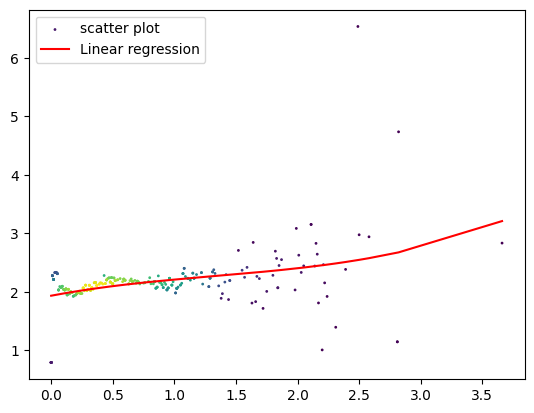

Fitted function: 0.04 * x^3 + -0.16 * x^2 + 0.4 * x + 1.93
MSE: 0.1589984228212499
R^2: 0.144713885166738
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


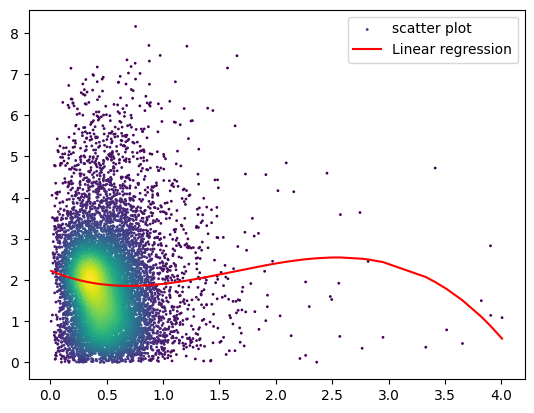

Fitted function: -0.22 * x^3 + 1.07 * x^2 + -1.17 * x + 2.23
MSE: 1.4006529
R^2: 0.004797041416168213


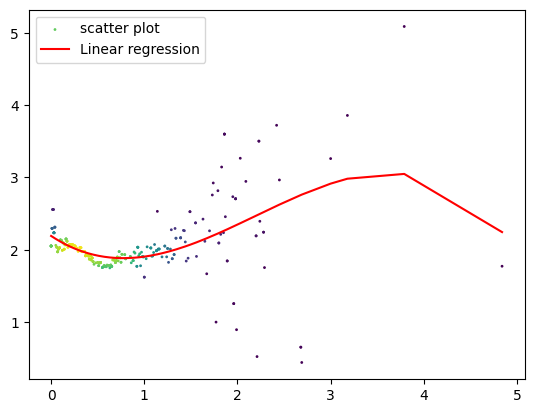

Fitted function: -0.1 * x^3 + 0.67 * x^2 + -0.85 * x + 2.19
MSE: 0.1416102581895366
R^2: 0.1939485394846917
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


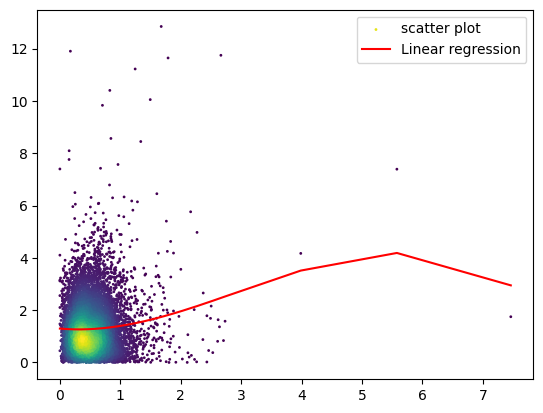

Fitted function: -0.04 * x^3 + 0.34 * x^2 + -0.2 * x + 1.3
MSE: 0.9744924
R^2: 0.00785815715789795


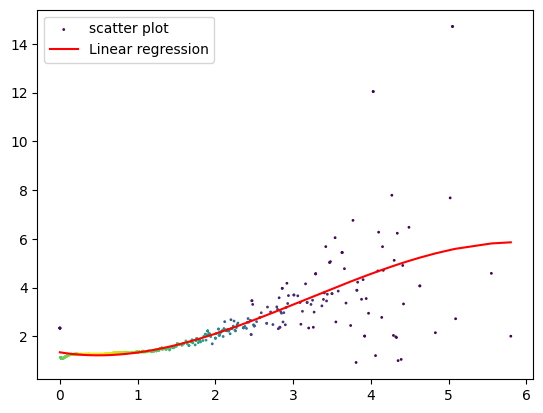

Fitted function: -0.06 * x^3 + 0.57 * x^2 + -0.52 * x + 1.35
MSE: 0.8526873773113062
R^2: 0.5732110574305597
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


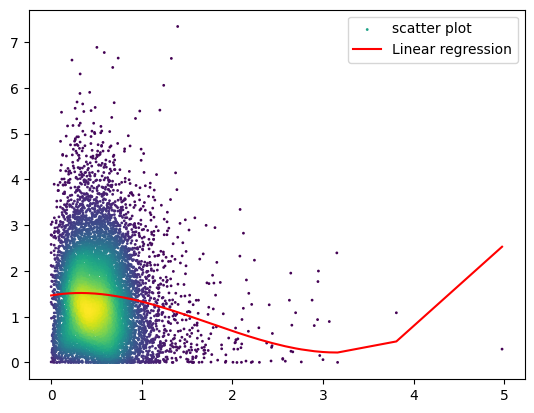

Fitted function: 0.11 * x^3 + -0.6 * x^2 + 0.35 * x + 1.46
MSE: 0.9356718
R^2: 0.013754129409790039


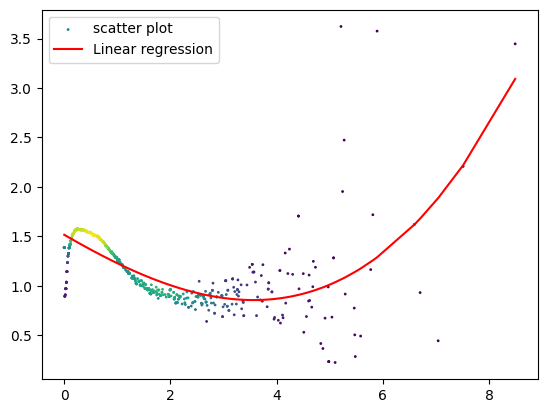

Fitted function: 0.0 * x^3 + 0.02 * x^2 + -0.31 * x + 1.52
MSE: 0.06177878959677594
R^2: 0.47376696311471167
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


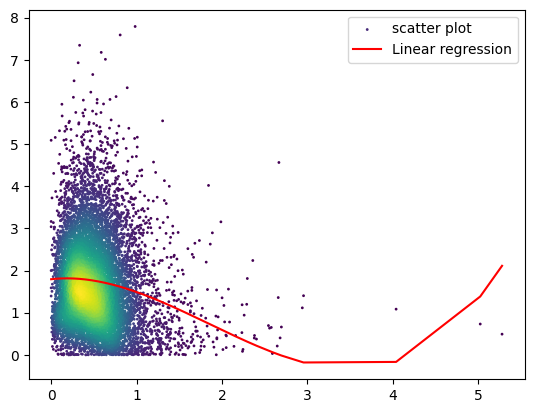

Fitted function: 0.12 * x^3 + -0.65 * x^2 + 0.23 * x + 1.79
MSE: 1.0906619
R^2: 0.023891329765319824


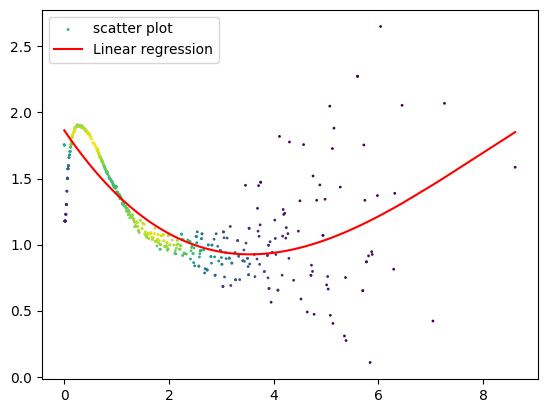

Fitted function: -0.0 * x^3 + 0.11 * x^2 + -0.59 * x + 1.86
MSE: 0.05608868671003358
R^2: 0.6235847799150794
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


KeyboardInterrupt: 

In [30]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)